In [1]:
%load_ext autoreload
%autoreload 2
# %config Application.verbose_crash=True

In [2]:
import os
from src.dataclasses.transactions import Transactions
from src.dataclasses.ticker import Ticker
from src.dataclasses.holdings import Holdings
from src.dataclasses.prices import Prices
from src.dataclasses.subscriptions import Subscriptions

from src.utils.defaults import DEFAULT_RFR

## Load in subscriptions

In [3]:
subscriptions = Subscriptions.from_csv(os.getcwd() + "/data/subscriptions.csv")
subscriptions.data.head()

,Portfolio,GBP,USD
Date,,,
2022-08-23,LISA,1993.88,2346.099947
2022-08-24,0,0.00,0.000000
2022-08-25,0,0.00,0.000000
2022-08-26,0,0.00,0.000000
2022-08-27,0,0.00,0.000000


## Load in transactions

In [4]:
transactions = Transactions.from_csv(os.getcwd() + "/data/full_transaction_history.csv")
transactions.raw_data.head()

,Portfolio,Date,Transaction,Description,Quantity,Price,Ticker
0,LISA,2022-08-23,Purchase,GameStop Corp Class A,32,30.00,GME
1,LISA,2022-08-23,Purchase,Vanguard S&P 500 UCITS ETF GBP,15,67.11,VUSA.L
2,LISA,2022-09-02,Purchase,GameStop Corp Class A,82,24.13,GME
3,LISA,2022-10-05,Purchase,GameStop Corp Class A,42,23.09,GME
4,ISA,2022-11-04,Purchase,iShares Core S&P 500 ETF USD Acc GBP,8,345.20,CSP1.L


In [5]:
Ticker("GBPUSD=X", is_fx=True).prices.tail()

Date
2025-11-14    1.315218
2025-11-15    1.315218
2025-11-16    1.315218
2025-11-17    1.316015
2025-11-18    1.314873
Freq: D, Name: GBPUSD=X, dtype: float64

In [6]:
from concurrent.futures import ThreadPoolExecutor


pool = ThreadPoolExecutor(max_workers=10)
prices = Prices(transactions=transactions, pool=pool)
prices.data.tail()

Loading prices: 100%|██████████| 11/11 [00:01<00:00,  7.14it/s]


,AMZN,GME,META,AAPL,GOOG,MU,ORCL,GXLK.L,CSP1.L,DJEL.L,VUSA.L
Date,,,,,,,,,,,
2025-11-14,234.690002,20.66,609.460022,272.410004,276.980011,246.830002,222.850006,154.735438,722.370515,479.166918,128.046366
2025-11-15,234.690002,20.66,609.460022,272.410004,276.980011,246.830002,222.850006,154.735438,722.370515,479.166918,128.046366
2025-11-16,234.690002,20.66,609.460022,272.410004,276.980011,246.830002,222.850006,154.735438,722.370515,479.166918,128.046366
2025-11-17,232.869995,20.50,602.010010,267.459991,285.600006,241.949997,219.860001,152.605057,718.649279,476.463103,127.377059
2025-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
holdings = Holdings(
    transactions=transactions, prices=prices, subscriptions=subscriptions
)

<Axes: >

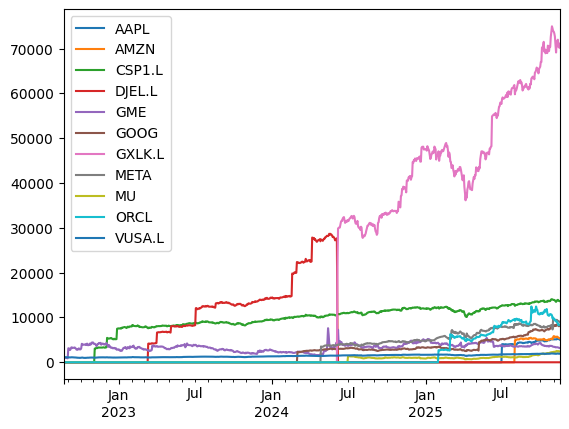

In [8]:
holdings.data.plot()

<Axes: xlabel='Date'>

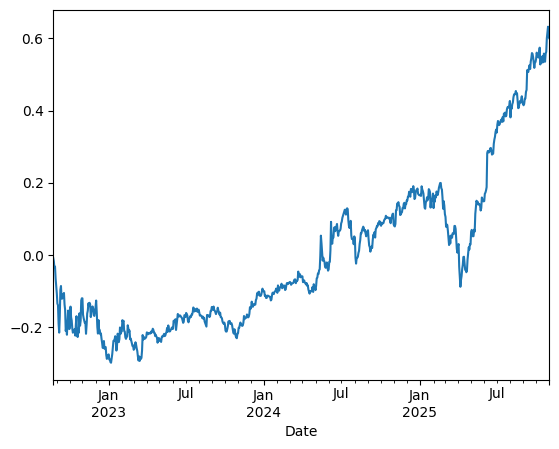

In [9]:
holdings.twr.add(1).cumprod().sub(1).plot()
# holdings.twr[holdings.twr > 0.1].resample("D").sum().fillna(0).plot()

In [10]:
holdings.transactions.data

Ticker,AAPL,AMZN,CSP1.L,DJEL.L,GME,GOOG,GXLK.L,META,MU,ORCL,VUSA.L
2022-08-23,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,15.0
2022-08-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Date'>

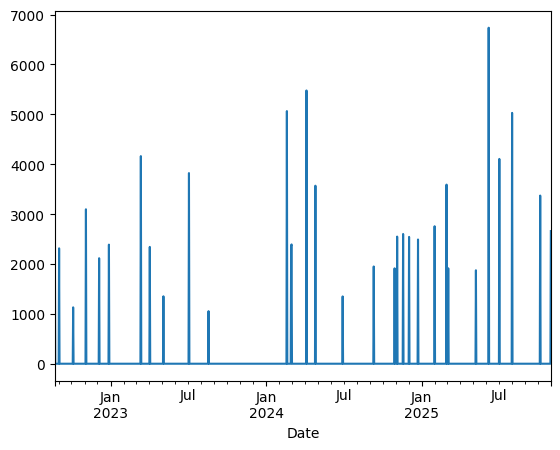

In [11]:
holdings.subscriptions.data["USD"].resample("D").sum().fillna(0).plot()

<Axes: xlabel='Date'>

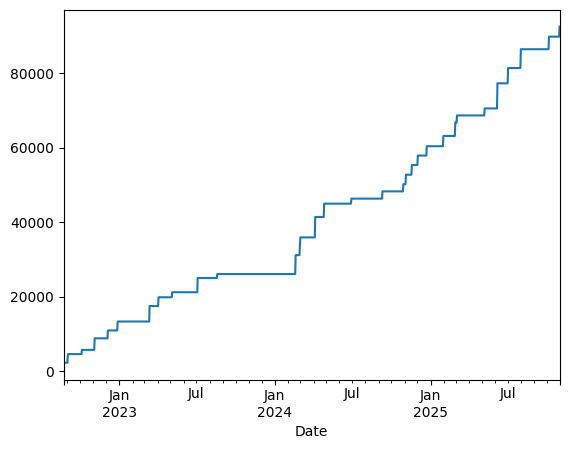

In [12]:
holdings.subscriptions.data["USD"].resample("D").sum().cumsum().fillna(0).plot()

<Axes: >

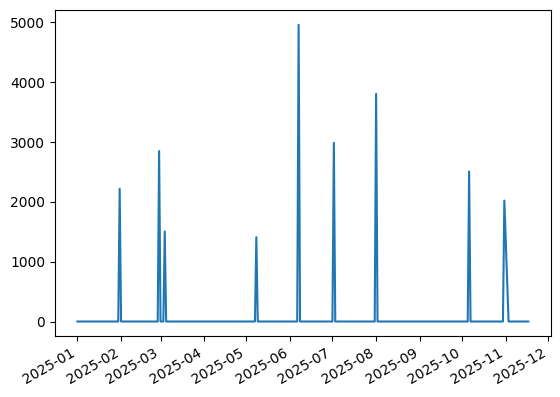

In [13]:
cfs = (
    holdings.subscriptions.data["GBP"]
    # .resample("D")
    # .sum()  # in case of multiple deposits per day
    .reindex(holdings.total.index.union(holdings.subscriptions.data.index))
    .fillna(0.0)
)

cfs["2025":].plot()

In [14]:
holdings.subscriptions.data["GBP"].max()

np.float64(4960.57)

In [15]:
subscriptions.data

,Portfolio,GBP,USD
Date,,,
2022-08-23,LISA,1993.88,2346.099947
2022-08-24,0,0.00,0.000000
2022-08-25,0,0.00,0.000000
2022-08-26,0,0.00,0.000000
2022-08-27,0,0.00,0.000000
...,...,...,...
2025-10-27,0,0.00,0.000000
2025-10-28,0,0.00,0.000000
2025-10-29,0,0.00,0.000000


<Axes: >

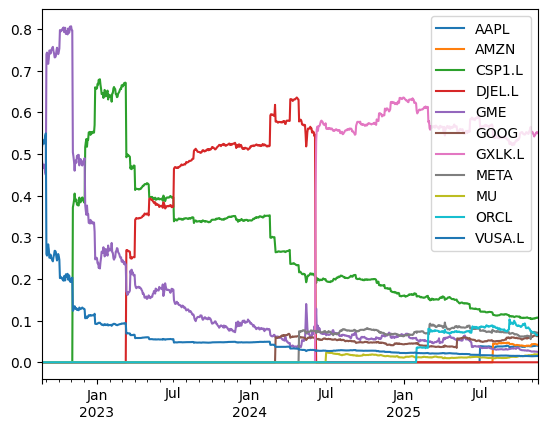

In [16]:
holdings.weights.plot()

In [17]:
bmk = Ticker("^SPX").returns
bmk

Date
2015-11-19   -0.001123
2015-11-20    0.003810
2015-11-21    0.000000
2015-11-22    0.000000
2015-11-23   -0.001235
                ...   
2025-11-13   -0.016557
2025-11-14   -0.000502
2025-11-15    0.000000
2025-11-16    0.000000
2025-11-17   -0.009162
Freq: D, Name: Returns, Length: 3652, dtype: float64

In [18]:
from src.dataclasses.assessment_config import AssessmentConfig


config = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,
    bmk=bmk,
)

In [19]:
from src.evaluation import Evaluation, ExecutorType

# executor = ExecutorType.ProcessPool()
# executor = ExecutorType.Remote("http://localhost:8000")
executor = ExecutorType.DEFAULT()


In [20]:
# %tb

# executor = ExecutorType.DEFAULT()



e = (Evaluation(config)
    # .with_assessment_types(["summary"]).with_assessments(["Beta"])
    # .with_pool(Pool.ProcessPool)
    # .with_assessments([AssessmentName.Beta])
    # .with_assessment_types(["rolling"])
    # .with_executor(executor=executor)
)




In [21]:
r = e.run()
r.timer_report()

ASSESSMENT TIMING REPORT

CVaR                |█████████████████                                 | 35.8% |    0.228s |
Down Capture        |█████████████                                     | 26.5% |    0.168s |
Up Capture          |███████████                                       | 23.5% |    0.149s |
Sharpe Ratio        |████                                              |  8.8% |    0.056s |
Calmar Ratio        |█                                                 |  2.0% |    0.013s |
Max Drawdown        |                                                  |  1.6% |    0.010s |
CAGR                |                                                  |  0.9% |    0.005s |
Value at Risk       |                                                  |  0.2% |    0.001s |
Beta                |                                                  |  0.2% |    0.001s |
Treynor Ratio       |                                                  |  0.2% |    0.001s |
Correlation         |                       

"============================================================================================\nASSESSMENT TIMING REPORT\n============================================================================================\n\nCVaR                |█████████████████                                 | 35.8% |    0.228s |\nDown Capture        |█████████████                                     | 26.5% |    0.168s |\nUp Capture          |███████████                                       | 23.5% |    0.149s |\nSharpe Ratio        |████                                              |  8.8% |    0.056s |\nCalmar Ratio        |█                                                 |  2.0% |    0.013s |\nMax Drawdown        |                                                  |  1.6% |    0.010s |\nCAGR                |                                                  |  0.9% |    0.005s |\nValue at Risk       |                                                  |  0.2% |    0.001s |\nBeta                |          

In [41]:
r.get_summary_results()

,Value
Beta,0.801488
CAGR,0.152922
Max Drawdown,-0.292340
Tracking Error,0.221017
Volatility,0.254604
Correlation,0.512391
Value at Risk,0.024394
CVaR,0.037178
Up Capture,92.949502
Down Capture,90.562046


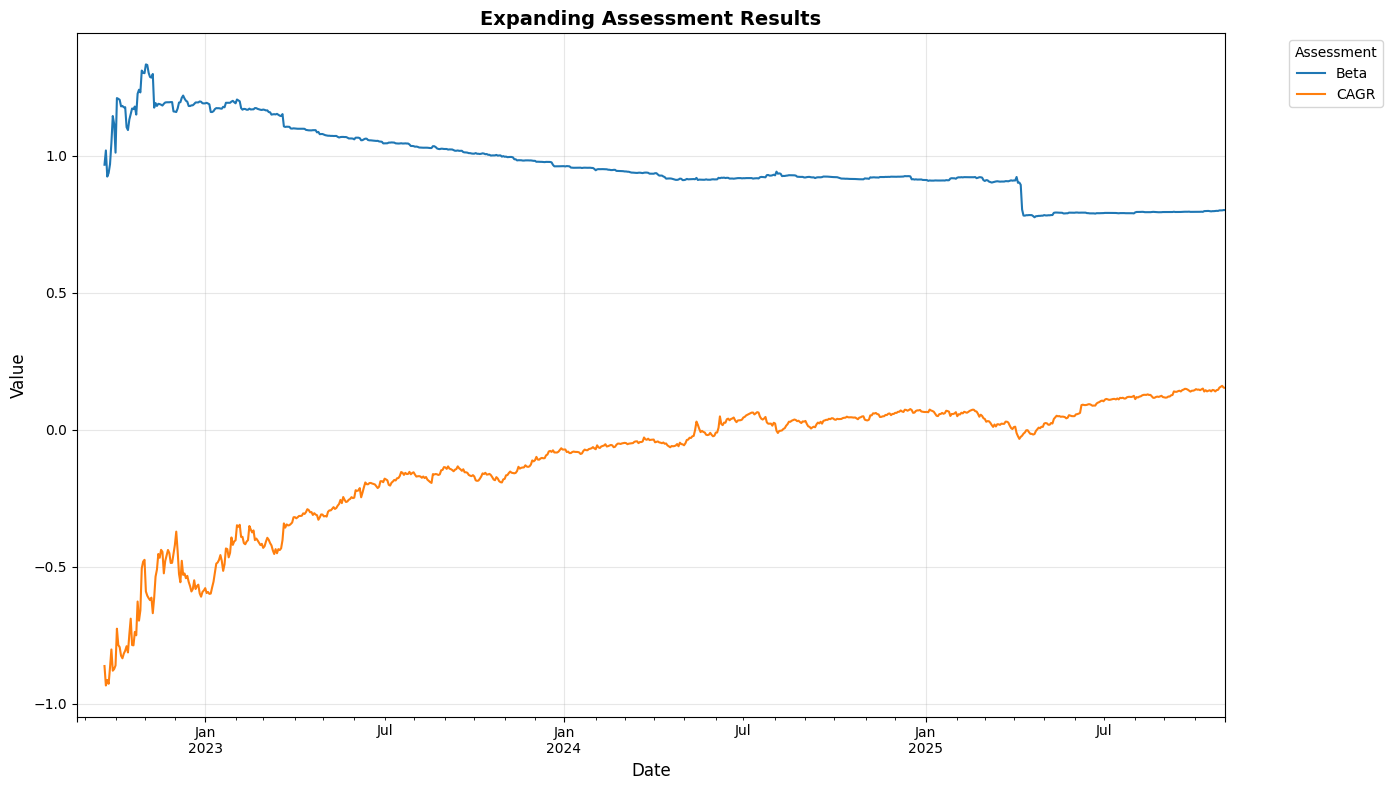

In [ ]:
r.plot_expanding(["Beta", "CAGR"])

In [23]:
# Had more capital and more focused on active mgmt
# (switched away from majority holding in DOW)
config_active = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,  # 3mo US Tresury
    bmk=bmk,  # SP500
    start="2024",
)

f_active = Evaluation(config_active).run()
# pd.Series(f_active.results)

In [24]:
config_active.bmk

Date
2024-01-01    0.000000
2024-01-02   -0.005661
2024-01-03   -0.008016
2024-01-04   -0.003428
2024-01-05    0.001826
                ...   
2025-10-27    0.012290
2025-10-28    0.002288
2025-10-29   -0.000044
2025-10-30   -0.009905
2025-10-31    0.002618
Freq: B, Name: Returns, Length: 480, dtype: float64

In [25]:
from src.assessments.beta import Beta


beta = Beta(config=config_active)


x = beta.summary()
# x = beta.rolling().plot()
# x = beta.expanding().plot()

# x.plot()
# bmk["2025":].add(1).cumprod().plot()
# beta.run("summary")
# beta.timer.df

#

<Axes: xlabel='Date'>

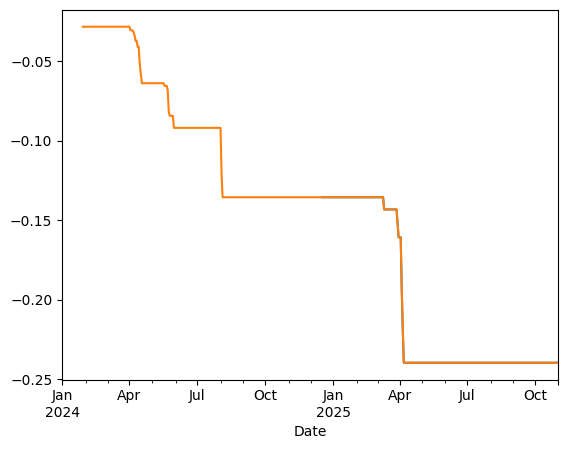

In [26]:
from src.assessments.max_drawdown import MaxDrawdown

max_dd = MaxDrawdown(config=config_active)
max_dd.summary()
max_dd.rolling().plot()
max_dd.expanding().plot()
# max_dd.results

<Axes: xlabel='Date'>

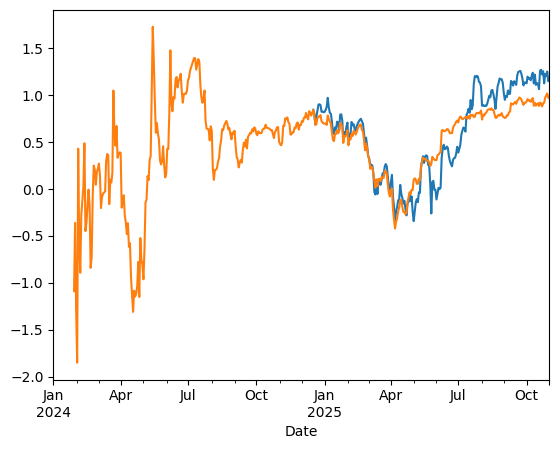

In [27]:
from src.assessments.sharpe_ratio import SharpeRatio

max_dd = SharpeRatio(config=config_active)
max_dd.summary()
max_dd.rolling().plot()
max_dd.expanding().plot()
# max_dd.results

<Axes: xlabel='Date'>

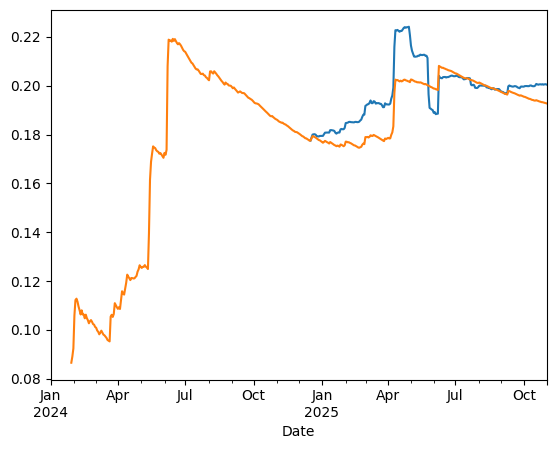

In [28]:
from src.assessments.tracking_error import TrackingError

tracking_error = TrackingError(config=config_active)
# tracking_error.summary()
tracking_error.rolling().plot()
tracking_error.expanding().plot()
# tracking_error.results

<Axes: xlabel='Date'>

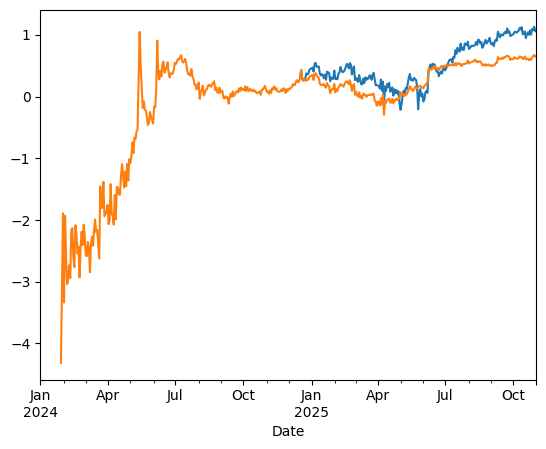

In [29]:
from src.assessments.information_ratio import InformationRatio

information_ratio = InformationRatio(config=config_active)
information_ratio.summary()
information_ratio.rolling().plot()
information_ratio.expanding().plot()

<Axes: xlabel='Date'>

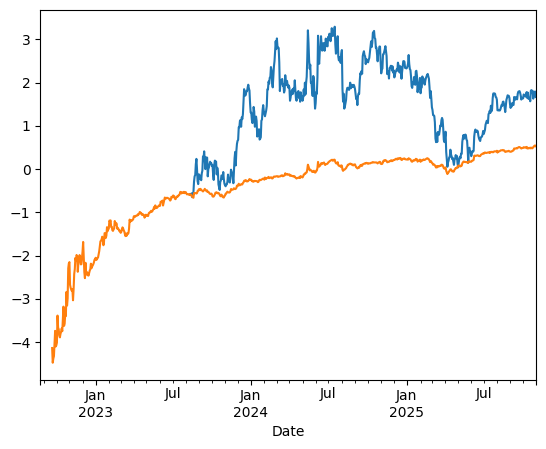

In [30]:
from src.assessments.calmar_ratio import CalmarRatio

calmar_ratio = CalmarRatio(config=config)
calmar_ratio.summary()
calmar_ratio.rolling().plot()
calmar_ratio.expanding().plot()

<Axes: xlabel='Date'>

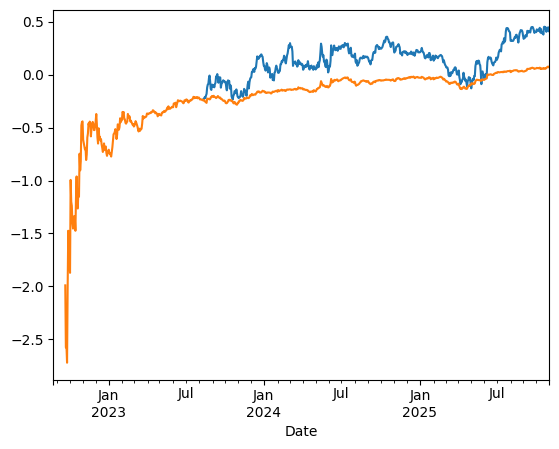

In [31]:
from src.assessments.treynor_ratio import TreynorRatio

treynor_ratio = TreynorRatio(config=config)
treynor_ratio.summary()
treynor_ratio.rolling().plot()
treynor_ratio.expanding().plot()

<Axes: xlabel='Date'>

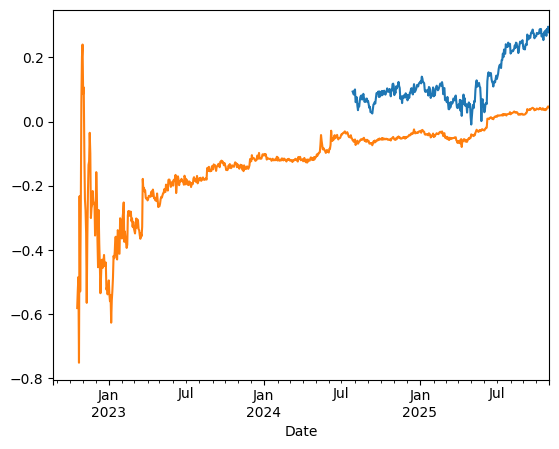

In [32]:
from src.assessments.jensens_alpha import JensensAlpha

jensens_alpha = JensensAlpha(config=config)
jensens_alpha.summary()
jensens_alpha.rolling().plot()
jensens_alpha.expanding().plot()

<Axes: xlabel='Date'>

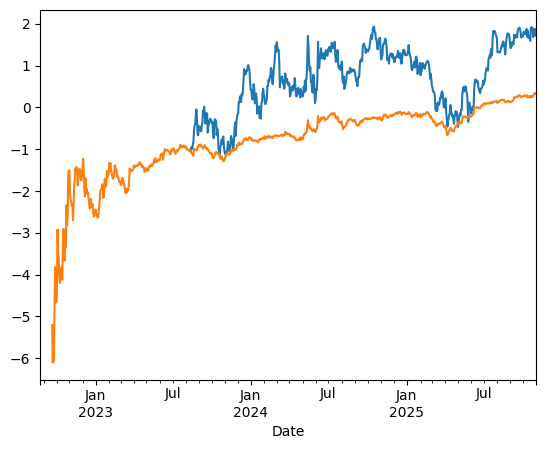

In [33]:
from src.assessments.sortino_ratio import SortinoRatio

sortino_ratio = SortinoRatio(config=config)
sortino_ratio.summary()
sortino_ratio.rolling().plot()
sortino_ratio.expanding().plot()

In [ ]:
from src.assessments.beta import Beta

b = Beta(config=config)
b.rolling()

Date
2022-02-10         NaN
2022-02-11         NaN
2022-02-14         NaN
2022-02-15         NaN
2022-02-16         NaN
                ...   
2025-10-27    0.665512
2025-10-28    0.664721
2025-10-29    0.664596
2025-10-30    0.668766
2025-10-31    0.668374
Freq: B, Length: 972, dtype: float64

In [ ]:
from src.assessments.max_drawdown import MaxDrawdown

b = MaxDrawdown(config=config)
b.rolling()

Date
2022-02-10         NaN
2022-02-11         NaN
2022-02-14         NaN
2022-02-15         NaN
2022-02-16         NaN
                ...   
2025-10-27   -0.242314
2025-10-28   -0.242314
2025-10-29   -0.242314
2025-10-30   -0.242314
2025-10-31   -0.242314
Freq: B, Length: 972, dtype: float64

<Axes: xlabel='Date'>

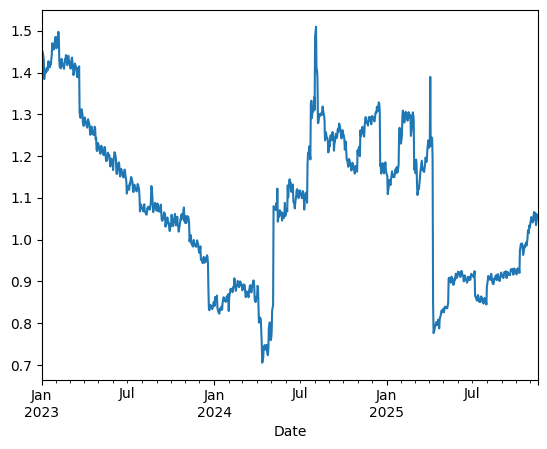

In [ ]:
window = 252  # span for EWM

# Portfolio and benchmark returns
returns = holdings.twr
benchmark = bmk

# EWM covariance between portfolio and benchmark
cov_ewm = returns.ewm(span=window).cov(benchmark)

# EWM variance of benchmark
var_ewm = benchmark.ewm(span=window).var()

# EWMA beta
beta_ewm = cov_ewm / var_ewm
beta_ewm["2023":].plot()

<Axes: xlabel='Date'>

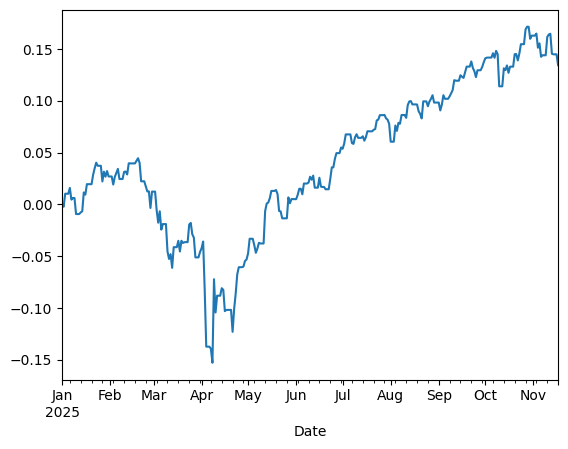

In [ ]:
bmk["2025":].add(1).cumprod().sub(1).plot()

<Axes: xlabel='Date'>

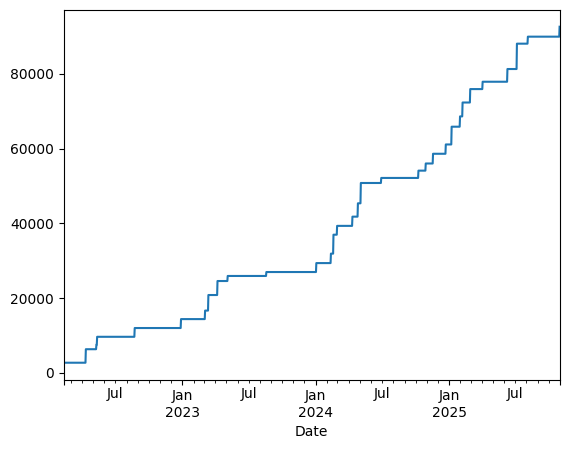

In [ ]:
subscriptions.data["USD"].cumsum().plot()

In [ ]:
from src.evaluation import Evaluation


e = Evaluation(config_active).with_assessments(
    # {AssessmentName.CAGR}
)
e.run()

Evaluation

In [ ]:
t = Ticker("ORCL")

In [ ]:
t.prices.resample("ME").last().pct_change().std() * 2

np.float64(0.1698097813140957)